In [1]:
import matplotlib.pyplot as plt
from avalanches.simulation import run_simulation_manybody
from avalanches.parallel_wrapper import parallel
import numpy as np
from scripts.analysis import stats, plots
import importlib

# Simulation

Inputs are:

N = width

L_max = number of layers

$\sigma_w^2/N$ and $\sigma_b^2$ = the variance of weights and biases, respectively

num_samples =  numper of perturbations

It is written for parallel computing. But the single runs can be used too (commented).

## Alternatively, the npy in the results section can be loaded

In [11]:
N = 500; L_max = 1000; sigw2 = 1.002; sigb2 = 0; num_samples = 2000000
no_shape = False # No avalanche shape, only size and duration recorded

### SAVE LOAD ######################
#np.save(f"results/avalanche_Shape{not no_shape}_N{N}_Lmax{L_max}_sigmaw2{sigw2}_sigmab2{sigb2}.npy",
 #       np.array(rec, dtype=object))
#rec = np.load(f"results/avalanche_Shape{not no_shape}_N{N}_Lmax{L_max}_sigmaw2{sigw2}_sigmab2{sigb2}.npy",
 #             allow_pickle=True)

### without parallelization: #######
#rec = run_simulation(N=N, L_max=L_max, sigma_w2=sigw2,sigma_b2 = sigb2,
#               num_samples=num_samples, print_every=1000, q0 = 0.01, no_shape = True)

### with parallelization: ##########
rec = parallel(
    run_simulation_manybody,
    split_arg="num_samples",
    num_workers=8,
    N=N, L_max=L_max,
    sigma_w2=sigw2, sigma_b2=sigb2,
    num_samples=num_samples,
    print_every=5000,
    q0=0.1, no_shape=no_shape,
)

if no_shape:
    s = np.array([x[0]*np.sqrt(N) for x in rec if x[1]<L_max-2])
    d = np.array([x[1]            for x in rec if x[1]<L_max-2])

else:
    s = np.array([np.sum(x)*np.sqrt(N) for x in rec if len(x)<L_max-2])
    d = np.array([len(x)               for x in rec if len(x)<L_max-2])


print(f'number of valid recorded avalanches = {len(d)}, shape record {not no_shape}')

[N=500, L=1000, sigma_w2=1.002] 5000/250000 (2.00%) done
[N=500, L=1000, sigma_w2=1.002] 5000/250000 (2.00%) done
[N=500, L=1000, sigma_w2=1.002] 5000/250000 (2.00%) done
[N=500, L=1000, sigma_w2=1.002] 5000/250000 (2.00%) done
[N=500, L=1000, sigma_w2=1.002] 5000/250000 (2.00%) done
[N=500, L=1000, sigma_w2=1.002] 5000/250000 (2.00%) done
[N=500, L=1000, sigma_w2=1.002] 5000/250000 (2.00%) done
[N=500, L=1000, sigma_w2=1.002] 5000/250000 (2.00%) done
[N=500, L=1000, sigma_w2=1.002] 10000/250000 (4.00%) done
[N=500, L=1000, sigma_w2=1.002] 10000/250000 (4.00%) done
[N=500, L=1000, sigma_w2=1.002] 10000/250000 (4.00%) done
[N=500, L=1000, sigma_w2=1.002] 10000/250000 (4.00%) done
[N=500, L=1000, sigma_w2=1.002] 10000/250000 (4.00%) done
[N=500, L=1000, sigma_w2=1.002] 10000/250000 (4.00%) done
[N=500, L=1000, sigma_w2=1.002] 10000/250000 (4.00%) done
[N=500, L=1000, sigma_w2=1.002] 10000/250000 (4.00%) done
[N=500, L=1000, sigma_w2=1.002] 15000/250000 (6.00%) done
[N=500, L=1000, sigma_

tau_s : 1.3050 +- 0.0004
tau_d : 1.5094 +- 0.0008
gamma : 1.5848 +- 0.0000
predicted gamma = 1.66997


Text(0, 0.5, '$\\langle S \\rangle(D)$')

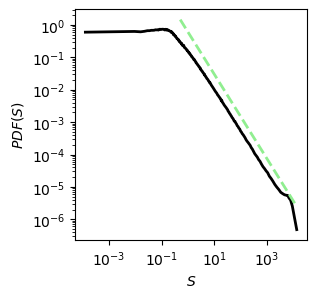

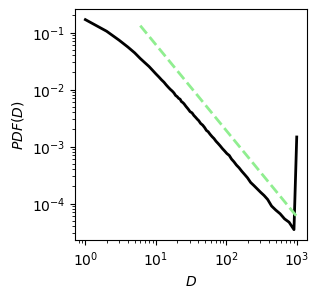

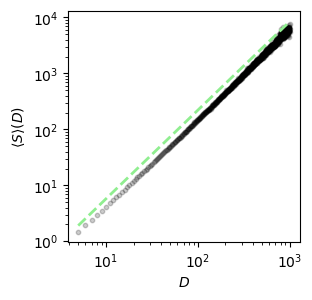

In [32]:
x_min_s = 0.5
x_min_d = 5
tau_s, tau_s_err = stats.MLE_exponent_tau(s,xmin=x_min_s,discrete=False)
print(f"tau_s : {tau_s:.4f} +- {tau_s_err:.4f}")
tau_d, tau_d_err = stats.MLE_exponent_tau(d,xmin=x_min_d,discrete=True)
print(f"tau_d : {tau_d:.4f} +- {tau_d_err:.4f}")

s_filtered, d_filtered = stats.coupled_filter(s,d, Dmin=x_min_d, Dmax=None, Smin=x_min_s, Smax=None)
gamma, gamma_err, intercept = stats.estimate_gamma_SD( s_filtered, d_filtered, min_count=100, Dmin=x_min_d, Dmax=None, weighted=True, eps_var=1e-8)
print(f"gamma : {gamma:.4f} +- {gamma_err:.4f}")
print(f'predicted gamma = {(tau_d - 1)/(tau_s - 1):.5f}')

######## FIGS ########

plt.figure(figsize=(3,3))
Dist_s = stats.distribution(s, discrete=False, xmin=None,xmax=None,min_count=3000)
plots.distribution_plot(Dist_s)
plots.distribution_plot_fit(Dist_s, tau_s, xmin=x_min_s,shift = 5)
plt.xlabel(r'$S$');plt.ylabel(r'$PDF(S)$')


plt.figure(figsize=(3,3))
Dist_d = stats.distribution(d, discrete=True, xmin=None,xmax=None,min_count=4000)
plots.distribution_plot(Dist_d)
plots.distribution_plot_fit(Dist_d, tau_d,xmin=x_min_d)
plt.xlabel(r'$D$');plt.ylabel(r'$PDF(D)$')

plt.figure(figsize=(3,3))
s_avg, d_avg = stats.avgS_D(s_filtered,d_filtered,min_count=0)
plots.ST_plot(s_avg, d_avg)
plots.ST_plot_fit(s_avg, d_avg, gamma= gamma, shift = -1)
plt.xlabel(r'$D$');plt.ylabel(r'$\langle S \rangle(D)$')


# Shape collapse (if no_shape == False)


Best γ  = 1.6100 ± 0.1296   (NMSE = 0.2036) and your γ  = 1.6100000000000003


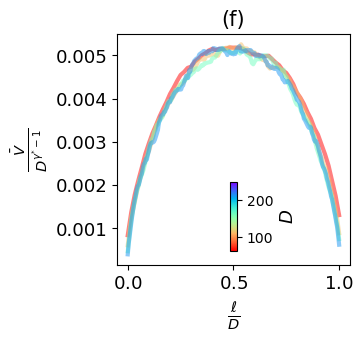

In [38]:
plt.figure(figsize=(3,3))
plots.shape_collapse_plot(rec, Tmin=60, Tmax=250, gamma = None,
                        cmap=plt.cm.rainbow_r, plot_every=50, alpha=.5, linewidth=3,
                        f_axis=15, f_ticks=13, f_title=15)

# $\sigma_w$-susceptibility
$\chi_{\sigma_w^2}(\bar S)$

In [39]:
N = 300; L_max = 500; sigb2 = 0; num_samples = 10000; no_shape = True

sigw2_list = np.linspace(0.95,1.4,20)

avg_avalanche_size = []

for sigw2 in sigw2_list:
    rec_ = parallel(
        run_simulation_manybody,
        split_arg="num_samples",
        num_workers=8,
        N=N, L_max=L_max,
        sigma_w2=sigw2, sigma_b2=sigb2,
        num_samples=num_samples,
        print_every=5000,
        q0=0.1, no_shape=no_shape,
    )

    s_ = np.array([x[0]*np.sqrt(N) for x in rec_ if x[1]<L_max-2])
    avg_avalanche_size.append(s_.mean())
    print(f'number of valid recorded avalanches = {len(d)}, sigma_w2 = {sigw2}')



number of valid recorded avalanches = 1002587, sigma_w2 = 0.95
number of valid recorded avalanches = 1002587, sigma_w2 = 0.9736842105263157
number of valid recorded avalanches = 1002587, sigma_w2 = 0.9973684210526316
number of valid recorded avalanches = 1002587, sigma_w2 = 1.0210526315789474
number of valid recorded avalanches = 1002587, sigma_w2 = 1.0447368421052632
number of valid recorded avalanches = 1002587, sigma_w2 = 1.068421052631579
number of valid recorded avalanches = 1002587, sigma_w2 = 1.0921052631578947
number of valid recorded avalanches = 1002587, sigma_w2 = 1.1157894736842104
number of valid recorded avalanches = 1002587, sigma_w2 = 1.1394736842105262
number of valid recorded avalanches = 1002587, sigma_w2 = 1.163157894736842
number of valid recorded avalanches = 1002587, sigma_w2 = 1.1868421052631577
number of valid recorded avalanches = 1002587, sigma_w2 = 1.2105263157894737
number of valid recorded avalanches = 1002587, sigma_w2 = 1.2342105263157894
number of valid

Text(0, 0.5, '$\\chi_{\\sigma_w^2}(\\bar S)$')

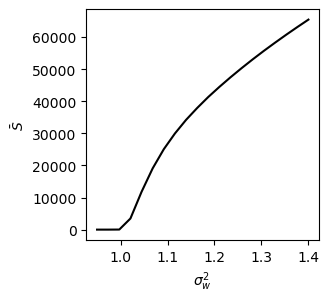

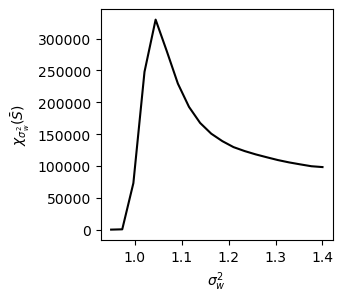

In [44]:
plt.figure(figsize=(3,3))
plt.plot(sigw2_list, avg_avalanche_size, color = 'k')
plt.xlabel(r'$\sigma_w^2$');plt.ylabel(r'$\bar S$')

plt.figure(figsize=(3,3))
plt.plot(sigw2_list, np.gradient(avg_avalanche_size,sigw2_list), color = 'k')
plt.xlabel(r'$\sigma_w^2$'); plt.ylabel(r'$\chi_{\sigma_w^2}(\bar S)$')